In [11]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

sns.set()

In [2]:
data = pd.read_csv("train.csv")
data.head()

,labels,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_1190,f_1191,f_1192,f_1193,f_1194,f_1195,f_1196,f_1197,f_1198,f_1199
0,0,-2.033875,0.978446,-0.142131,-0.177117,-1.470684,1.669562,-0.196530,-0.125239,-0.452284,...,-1.111266,0.716084,0.060039,0.301279,-1.174846,-1.076498,-0.069452,-0.604012,-2.179176,0.558003
1,1,-0.348835,0.294815,-0.557577,-2.020773,-1.234715,1.633930,-1.680658,-0.358146,0.166122,...,0.735240,0.829781,1.521941,1.347946,0.754505,1.330642,-0.754453,0.582956,0.252671,1.495870
2,1,0.113248,-0.607726,-0.947791,0.830851,0.998291,0.498321,-1.493958,0.789572,-1.311018,...,0.104698,0.616189,-1.035953,2.111387,-0.984415,1.148076,-1.433554,0.243372,0.170083,1.274795
3,0,1.223321,-0.479048,-1.925789,1.680377,0.021840,-1.453307,0.605559,-0.019024,1.065448,...,0.360237,-1.957863,-0.123384,1.505329,0.660290,-1.769443,-0.547756,-0.568122,0.244645,0.982116
4,0,0.160109,0.422684,-0.308029,0.227744,0.432854,0.608348,0.193832,1.035091,-0.538868,...,0.416629,1.441766,0.212572,-0.994721,1.143999,-2.166923,-1.199248,-1.028636,0.752791,0.317169


In [6]:
for x in (data.isnull().sum()):
    if x != 0:
        print("Null found at ", x)

In [15]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

df_scaled = pd.DataFrame(scaled_data, columns=data.columns)
df_scaled.head()

,labels,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_1190,f_1191,f_1192,f_1193,f_1194,f_1195,f_1196,f_1197,f_1198,f_1199
0,-0.603023,-2.604266,0.991972,-0.473765,-0.605116,-1.614553,1.671046,-0.022425,-0.055823,-0.325416,...,-1.624559,1.063572,-0.032807,0.583405,-0.999795,-0.902615,0.029085,-1.033815,-2.009790,0.614850
1,1.658312,-0.790418,0.231447,-0.902375,-2.536834,-1.370918,1.631245,-1.504373,-0.312871,0.310758,...,0.337170,1.171431,1.491790,1.640938,0.851902,1.458978,-0.720660,0.223115,0.488134,1.660502
2,1.658312,-0.293013,-0.772610,-1.304954,0.450997,0.934638,0.362784,-1.317948,0.953811,-1.208823,...,-0.332718,0.968807,-1.175800,2.412305,-0.817028,1.279866,-1.463948,-0.136485,0.403303,1.414020
3,-0.603023,0.901916,-0.629459,-2.313940,1.341100,-0.073537,-1.817159,0.778487,0.061402,1.235924,...,-0.061234,-1.473064,-0.224096,1.799955,0.761479,-1.582447,-0.494427,-0.995809,0.479890,1.087704
4,-0.603023,-0.242570,0.373698,-0.644921,-0.180917,0.350830,0.485683,0.367364,1.224779,-0.414487,...,-0.001323,1.751990,0.126268,-0.726049,1.225719,-1.972406,-1.207496,-1.483468,1.001844,0.346338


In [19]:
y = data['labels']
x = df_scaled.drop(columns=['labels'])

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state= 42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4200, 1200)
(4200,)
(1050, 1200)
(1050,)


# Finding Learning Rate

In [23]:
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 40))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model_tune.fit(x_train, y_train, epochs=50, callbacks=[lr_schedule])

Epoch 1/50
132/132 [==============================] - 30s 204ms/step - loss: 0.1282 - lr: 1.0000e-04
Epoch 2/50
132/132 [==============================] - 37s 283ms/step - loss: 0.1129 - lr: 1.0593e-04
Epoch 3/50
132/132 [==============================] - 24s 182ms/step - loss: 0.1062 - lr: 1.1220e-04
Epoch 4/50
132/132 [==============================] - 24s 180ms/step - loss: 0.1033 - lr: 1.1885e-04
Epoch 5/50
132/132 [==============================] - 24s 178ms/step - loss: 0.1021 - lr: 1.2589e-04
Epoch 6/50
132/132 [==============================] - 22s 164ms/step - loss: 0.1016 - lr: 1.3335e-04
Epoch 7/50
132/132 [==============================] - 22s 165ms/step - loss: 0.1012 - lr: 1.4125e-04
Epoch 8/50
132/132 [==============================] - 22s 167ms/step - loss: 0.1010 - lr: 1.4962e-04
Epoch 9/50
132/132 [==============================] - 22s 168ms/step - loss: 0.1007 - lr: 1.5849e-04
Epoch 10/50
132/132 [==============================] - 23s 173ms/step - loss: 0.1005 - lr: 

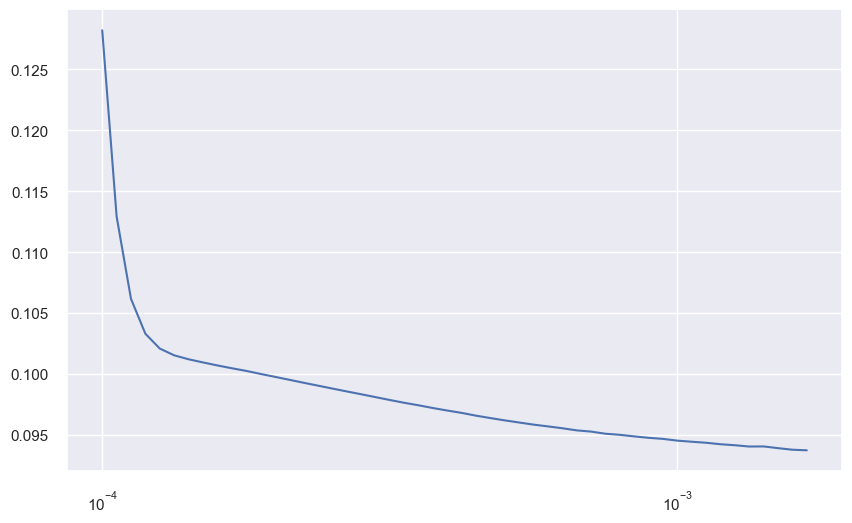

In [25]:
lrs = 1e-4 * (10 ** (np.arange(50) / 40))
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')

# Actual Model

In [18]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('val_accuracy') is not None and logs.get('val_accuracy') >= 0.98:                 
            print("\nReached 88% accuracy so cancelling training!")
            self.model.stop_training = True 

In [34]:
callbacks = myCallback()

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate= 0.01, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer,
              metrics=['accuracy'])

In [35]:
history = model.fit(x_train, y_train, epochs = 70, callbacks=[callbacks], validation_data= (x_test, y_test))

Epoch 1/70
132/132 [==============================] - 29s 199ms/step - loss: 0.0978 - accuracy: 0.7307 - val_loss: 0.0916 - val_accuracy: 0.7429
Epoch 2/70
132/132 [==============================] - 24s 183ms/step - loss: 0.0944 - accuracy: 0.7279 - val_loss: 0.0912 - val_accuracy: 0.7429
Epoch 3/70
 31/132 [======>.......................] - ETA: 16s - loss: 0.0939 - accuracy: 0.7218

KeyboardInterrupt: 

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_{}".format(metric)])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")